In [90]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
import os
import datetime as dt
from datetime import timedelta, date

# EDA

First we need to import the incident list dataframe

In [91]:
df = pd.read_csv('df.csv')

The longitude and latitude of each address was found in the 'Google Geocoding API' notebook. We'll import a dataframe of all unique addresses with their coordinates and indicent count here.

In [92]:
df_address_geo = pd.read_csv('df_address_geo.csv')

Now we add the coordinates to the incidents dataframe

In [93]:
df = df.merge(df_address_geo.drop('incidentCount', axis=1), on='address', how='left')
df.head()

,ccn,date,city,state,blocksizedAddress,parentIncidentType,narrative,address,lat,lng
0,CA23018227,"12/25/2022, 12:00:00 AM",LETHBRIDGE,AB,1600 Block ST GEORGE RD,Assault,Assault,"1600 ST GEORGE RD, LETHBRIDGE, AB, Canada",49.719971,-112.832000
1,CA23016523,"12/01/2022, 9:04:00 AM",LETHBRIDGE,AB,100 Block GOLDENROD RD,Other,Fraud - Identity Fraud,"100 GOLDENROD RD, LETHBRIDGE, AB, Canada",49.693938,-112.910940
2,RM23054146,"10/21/2022, 4:00:00 PM",LETHBRIDGE,AB,100 Block FAIRMONT BD,Other,Proceeds Of Crime Criminal Cod,"100 FAIRMONT BD, LETHBRIDGE, AB, Canada",49.666273,-112.789834
3,CA23008687,"11/01/2022, 7:00:00 AM",LETHBRIDGE,AB,1 Block BLACKFOOT CI,Sexual Offense,Sexual Assault,"1 BLACKFOOT CI, LETHBRIDGE, AB, Canada",49.679674,-112.896003
4,RM22058254,"12/16/2022, 1:00:00 PM",LETHBRIDGE,AB,100 Block 1 AV,Other,Assist Others,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058


Let's visualize the number of incidents for each block on a scatter plot

In [94]:
df_address_geo['incidentCount'].max()

2193

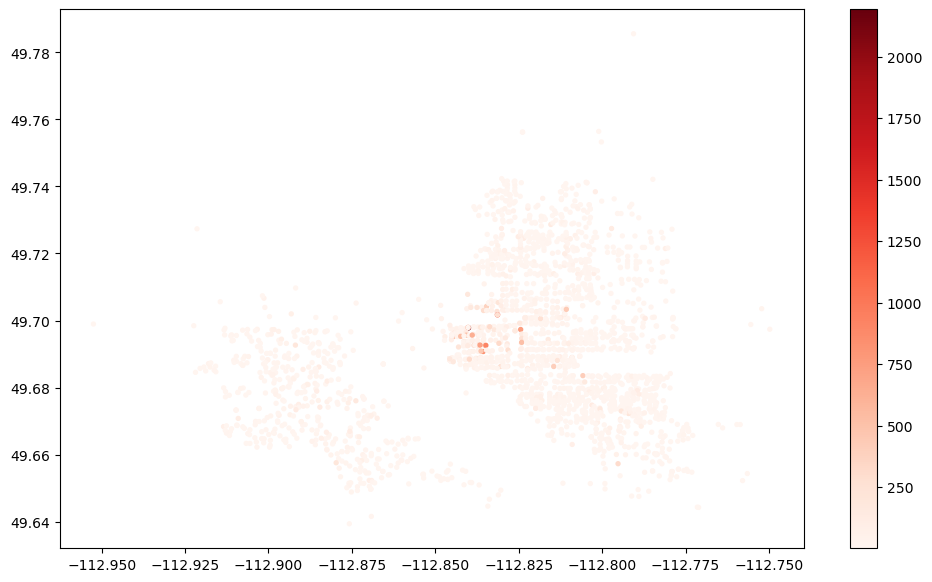

In [95]:
plt.figure(figsize=(12,7))
plt.scatter(df_address_geo['lng'], df_address_geo['lat'], c=df_address_geo['incidentCount'], cmap='Reds', s=8)
plt.colorbar()

# Creating Block-Hour DataFrame

Now we need to make a dataframe where each row is a unique 'block-hour'.  Let's start by converting date strings to datetimes.

In [96]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/63736465.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/63736465.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [97]:
"""

df_incidents = df.drop(['ccn', 'city', 'state', 'blocksizedAddress', 'narrative', 'parentIncidentType'], axis=1)

conditions = [
    df_blockDay['date'].dt.hour,
    df_blockDay['date'].dt.month.isin([3,4,5]),
    df_blockDay['date'].dt.month.isin([6,7,8]),
    df_blockDay['date'].dt.month.isin([9,10,11])
    ]

choices = [
    'winter',
    'spring',
    'summer',
    'fall'
    ]

df_blockDay.insert(2, 'season', np.select(conditions,choices,default='?'))

"""

"\n\ndf_incidents = df.drop(['ccn', 'city', 'state', 'blocksizedAddress', 'narrative', 'parentIncidentType'], axis=1)\n\nconditions = [\n    df_blockDay['date'].dt.hour,\n    df_blockDay['date'].dt.month.isin([3,4,5]),\n    df_blockDay['date'].dt.month.isin([6,7,8]),\n    df_blockDay['date'].dt.month.isin([9,10,11])\n    ]\n\nchoices = [\n    'winter',\n    'spring',\n    'summer',\n    'fall'\n    ]\n\ndf_blockDay.insert(2, 'season', np.select(conditions,choices,default='?'))\n\n"

In [98]:
df_incidentBlockDate = df.pivot_table(index=['address', df['date'].dt.date], values='lat', aggfunc='count').reset_index()
df_incidentBlockDate.columns = ['address','date','incidentCount']
df_incidentBlockDate['date'] = pd.to_datetime(df_incidentBlockDate['date'])

In [99]:
df_incidentBlockDate

,address,date,incidentCount
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-12,2
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-14,1
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-17,1
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-31,1
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-11-02,1
...,...,...,...
27621,"900 STAFFORD DR, LETHBRIDGE, AB, Canada",2023-04-26,1
27622,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2022-11-24,1
27623,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-01-15,1
27624,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-01-21,2


In [100]:
df_address_geo

,address,incidentCount,lat,lng
0,"1 1 AV, LETHBRIDGE, AB, Canada",24,49.697474,-112.850887
1,"1 3 ST, LETHBRIDGE, AB, Canada",22,49.703527,-112.752190
2,"1 5 AV, LETHBRIDGE, AB, Canada",5,49.692750,-112.841036
3,"1 62 AV, LETHBRIDGE, AB, Canada",4,49.756413,-112.801033
4,"1 ABERDEEN BY, LETHBRIDGE, AB, Canada",1,49.695618,-112.845107
...,...,...,...,...
2220,"900 PACIFIC WY, LETHBRIDGE, AB, Canada",3,49.684965,-112.918823
2221,"900 RED CROW BD, LETHBRIDGE, AB, Canada",5,49.680261,-112.889503
2222,"900 SCENIC DR, LETHBRIDGE, AB, Canada",2,49.685511,-112.840768
2223,"900 STAFFORD DR, LETHBRIDGE, AB, Canada",5,49.705218,-112.833984


In [101]:
# Creating a dataframe that has a row for every combination of address (block) and date

date_min = df['date'].min().date()
date_max = df['date'].max().date() + timedelta(days=1)

addresses = df_address_geo['address']
dates = pd.date_range(start=date_min, end=date_max)
time_interval = ['00:00-06:00', '06:00-12:00', '12:00-18:00', '18:00-24:00']

df_blockDay = pd.DataFrame([(a,d) for a in addresses for d in dates])
df_blockDay.columns = ['address', 'date']
df_blockDay = df_blockDay.merge(df_incidentBlockDate, on=['address','date'], how='left').fillna(0)

df_blockDay = df_blockDay.merge(df_address_geo, on='address', how='left')
df_blockDay.columns = ['address', 'date', 'incidentCount', 'lat', 'lng', 'averageIncidentCount']
df_blockDay['averageIncidentCount'] = df_blockDay['averageIncidentCount']/((date_max - date_min).days + 1)

df_blockDay.insert(5, 'incidentOccurred?', (df_blockDay['incidentCount'] > 0)*1)
df_blockDay.insert(2, 'dayOfWeek', df_blockDay['date'].dt.strftime('%A'))

df_blockDay

,address,date,dayOfWeek,incidentCount,lat,lng,incidentOccurred?,averageIncidentCount
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,Saturday,0.0,24,49.697474,0,-0.410367
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,Sunday,0.0,24,49.697474,0,-0.410367
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,Monday,0.0,24,49.697474,0,-0.410367
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,Tuesday,0.0,24,49.697474,0,-0.410367
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,Wednesday,0.0,24,49.697474,0,-0.410367
...,...,...,...,...,...,...,...,...
611870,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-28,Wednesday,0.0,7,49.714012,0,-0.410322
611871,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-29,Thursday,0.0,7,49.714012,0,-0.410322
611872,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-30,Friday,0.0,7,49.714012,0,-0.410322
611873,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-07-01,Saturday,0.0,7,49.714012,0,-0.410322


In [102]:
df_timeseries = df_blockDay.pivot_table(index='date', values='incidentCount', aggfunc='sum').reset_index()
df_timeseries

,date,incidentCount
0,2022-10-01,138.0
1,2022-10-02,219.0
2,2022-10-03,224.0
3,2022-10-04,202.0
4,2022-10-05,224.0
...,...,...
270,2023-06-28,212.0
271,2023-06-29,194.0
272,2023-06-30,225.0
273,2023-07-01,85.0


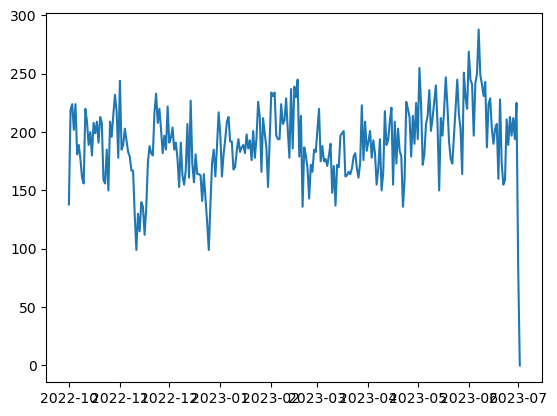

In [103]:
plt.plot(df_timeseries['date'],df_timeseries['incidentCount'])

In [104]:
df_blockDay['incidentOccurred?'].value_counts()

incidentOccurred?
0    584249
1     27626
Name: count, dtype: int64

In [105]:
df_blockDay

,address,date,dayOfWeek,incidentCount,lat,lng,incidentOccurred?,averageIncidentCount
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,Saturday,0.0,24,49.697474,0,-0.410367
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,Sunday,0.0,24,49.697474,0,-0.410367
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,Monday,0.0,24,49.697474,0,-0.410367
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,Tuesday,0.0,24,49.697474,0,-0.410367
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,Wednesday,0.0,24,49.697474,0,-0.410367
...,...,...,...,...,...,...,...,...
611870,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-28,Wednesday,0.0,7,49.714012,0,-0.410322
611871,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-29,Thursday,0.0,7,49.714012,0,-0.410322
611872,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-06-30,Friday,0.0,7,49.714012,0,-0.410322
611873,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-07-01,Saturday,0.0,7,49.714012,0,-0.410322


In [106]:
df[df['date'].dt.date==date(2022,10,5)]

,ccn,date,city,state,blocksizedAddress,parentIncidentType,narrative,address,lat,lng
68,CA22022522,2022-10-05 15:00:00,LETHBRIDGE,AB,1800 Block 23 ST,Other,Check On Welfare,"1800 23 ST, LETHBRIDGE, AB, Canada",49.720937,-112.810393
410,CA22022053,2022-10-05 06:16:00,LETHBRIDGE,AB,2300 Block 13 ST,Theft from Vehicle,Theft From Auto Under,"2300 13 ST, LETHBRIDGE, AB, Canada",49.725008,-112.825161
4663,AR22100771,2022-10-05 23:04:00,LETHBRIDGE,AB,1 Block HERITAGE BD,Theft from Vehicle,Mischief to MV,"1 HERITAGE BD, LETHBRIDGE, AB, Canada",49.693513,-112.888448
11149,CA22022099,2022-10-05 17:12:00,LETHBRIDGE,AB,1 Block PARK MEADOWS BD,Other,Check On Welfare,"1 PARK MEADOWS BD, LETHBRIDGE, AB, Canada",49.721026,-112.810262
12517,CA22022040,2022-10-05 03:51:00,LETHBRIDGE,AB,1100 Block 27 ST,Other,Landlord & Tenant,"1100 27 ST, LETHBRIDGE, AB, Canada",49.681706,-112.802900
...,...,...,...,...,...,...,...,...,...,...
15942,P22047143,2022-10-05 01:53:25,LETHBRIDGE,AB,500 Block STAFFORD DR,Quality of Life,DISTURBANCE/NUISANCE,"500 STAFFORD DR, LETHBRIDGE, AB, Canada",49.705223,-112.833880
15943,P22047144,2022-10-05 01:54:15,LETHBRIDGE,AB,500 Block 21 ST,Other,"PUBLIC SERVICE (LOCK-OUT/LOCK-IN, PEACE, WELFA...","500 21 ST, LETHBRIDGE, AB, Canada",49.693111,-112.811428
15947,P22047130,2022-10-05 00:03:29,LETHBRIDGE,AB,200 Block 4 AV,Other,SUPPLEMENTAL,"200 4 AV, LETHBRIDGE, AB, Canada",49.693695,-112.841379
15948,P22047132,2022-10-05 00:17:26,LETHBRIDGE,AB,600 Block 8 ST,Sexual Offense,SEXUAL ASSAULT,"600 8 ST, LETHBRIDGE, AB, Canada",49.690751,-112.835657


In [107]:
df_blockDay_training = df_blockDay[df_blockDay['date'].dt.date < date(2023,6,1)]
df_blockDay_test = df_blockDay[df_blockDay['date'].dt.date >= date(2023,6,1)]

In [108]:
df_blockDay_training

,address,date,dayOfWeek,incidentCount,lat,lng,incidentOccurred?,averageIncidentCount
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,Saturday,0.0,24,49.697474,0,-0.410367
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,Sunday,0.0,24,49.697474,0,-0.410367
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,Monday,0.0,24,49.697474,0,-0.410367
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,Tuesday,0.0,24,49.697474,0,-0.410367
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,Wednesday,0.0,24,49.697474,0,-0.410367
...,...,...,...,...,...,...,...,...
611838,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-27,Saturday,0.0,7,49.714012,0,-0.410322
611839,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-28,Sunday,0.0,7,49.714012,0,-0.410322
611840,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-29,Monday,0.0,7,49.714012,0,-0.410322
611841,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-05-30,Tuesday,0.0,7,49.714012,0,-0.410322


In [109]:
df_address_geo = df_address_geo.sort_values('incidentCount',ascending = False)
df_address_geo['incidentCummSum'] = np.cumsum(df_address_geo['incidentCount'])/df_address_geo['incidentCount'].sum()

In [110]:
df_address_geo[df_address_geo['incidentCummSum'] < 0.50]

,address,incidentCount,lat,lng,incidentCummSum
391,"100 1 AV, LETHBRIDGE, AB, Canada",2193,49.697816,-112.840058,0.041909
2143,"800 2A AV, LETHBRIDGE, AB, Canada",1361,49.701727,-112.831368,0.067918
2149,"800 5 AV, LETHBRIDGE, AB, Canada",925,49.692594,-112.834855,0.085595
1907,"500 1 AV, LETHBRIDGE, AB, Canada",864,49.697940,-112.840158,0.102106
2035,"600 8 ST, LETHBRIDGE, AB, Canada",832,49.690751,-112.835657,0.118006
...,...,...,...,...,...
770,"1300 23 AV, LETHBRIDGE, AB, Canada",105,49.724552,-112.823450,0.491668
974,"1700 23 ST, LETHBRIDGE, AB, Canada",103,49.719912,-112.811238,0.493636
415,"100 ALGONQUIN RD, LETHBRIDGE, AB, Canada",103,49.681929,-112.882415,0.495605
1972,"500 MAYOR MAGRATH DR, LETHBRIDGE, AB, Canada",102,49.693084,-112.810123,0.497554


In [111]:
90/2225

0.04044943820224719

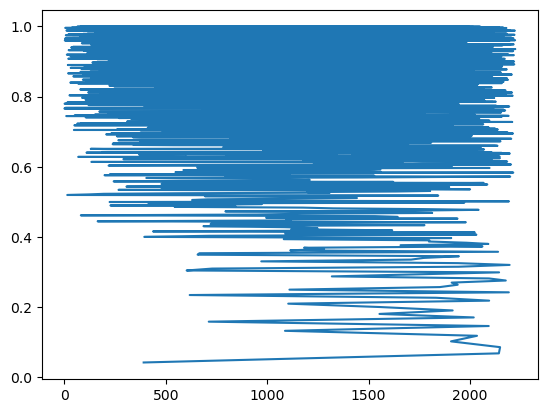

In [112]:
plt.plot(df_address_geo.index,df_address_geo['incidentCummSum'])

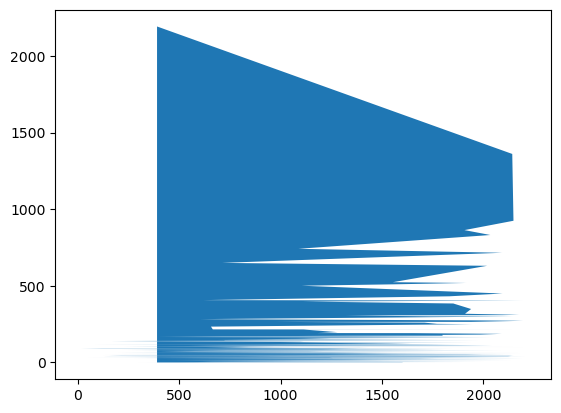

In [113]:
plt.fill_between(df_address_geo.index,df_address_geo['incidentCount'])

## All-Time Hotspots

In [114]:
threshold = 0.250

df_hotspot = df_blockDay_training.pivot_table(index='address', values='incidentOccurred?', aggfunc='mean').reset_index()
df_hotspot = df_hotspot.sort_values('incidentOccurred?',ascending=False)
df_hotspot.columns = ['address','incidentChance']
df_hotspot = df_hotspot[df_hotspot['incidentChance']>=threshold]
df_hotspot.count()

address           72
incidentChance    72
dtype: int64

In [115]:
df_blockDay_test['Hotspot Prediction'] = df_blockDay_test['address'].isin(df_hotspot['address'])*1

/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/3288250573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blockDay_test['Hotspot Prediction'] = df_blockDay_test['address'].isin(df_hotspot['address'])*1


In [116]:
def print_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    cf = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cf, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Confusion Matrix')

In [125]:
df_test = df_blockDay[['address', 'incidentOccurred?']].pivot_table(index='address', values='incidentOccurred?', aggfunc='mean').reset_index()
df_test.columns = 

df_address_geo.merge(df_test, on='address', how='left')

,address,incidentCount,lat,lng,incidentCummSum,incidentOccurred?
0,"100 1 AV, LETHBRIDGE, AB, Canada",2193,49.697816,-112.840058,0.041909,0.985455
1,"800 2A AV, LETHBRIDGE, AB, Canada",1361,49.701727,-112.831368,0.067918,0.941818
2,"800 5 AV, LETHBRIDGE, AB, Canada",925,49.692594,-112.834855,0.085595,0.912727
3,"500 1 AV, LETHBRIDGE, AB, Canada",864,49.697940,-112.840158,0.102106,0.840000
4,"600 8 ST, LETHBRIDGE, AB, Canada",832,49.690751,-112.835657,0.118006,0.810909
...,...,...,...,...,...,...
2220,"1000 2A, LETHBRIDGE, AB, Canada",1,49.695618,-112.845107,0.999924,0.003636
2221,"1 ST & ST EDWARD BD, LETHBRIDGE, AB, Canada",1,49.720126,-112.829140,0.999943,0.003636
2222,"1600 26 ST, LETHBRIDGE, AB, Canada",1,49.675920,-112.804433,0.999962,0.003636
2223,"1 ST & 41 AV, LETHBRIDGE, AB, Canada",1,49.695618,-112.845107,0.999981,0.003636


In [122]:
df_address_geo

,address,incidentCount,lat,lng,incidentCummSum
391,"100 1 AV, LETHBRIDGE, AB, Canada",2193,49.697816,-112.840058,0.041909
2143,"800 2A AV, LETHBRIDGE, AB, Canada",1361,49.701727,-112.831368,0.067918
2149,"800 5 AV, LETHBRIDGE, AB, Canada",925,49.692594,-112.834855,0.085595
1907,"500 1 AV, LETHBRIDGE, AB, Canada",864,49.697940,-112.840158,0.102106
2035,"600 8 ST, LETHBRIDGE, AB, Canada",832,49.690751,-112.835657,0.118006
...,...,...,...,...,...
586,"1000 2A, LETHBRIDGE, AB, Canada",1,49.695618,-112.845107,0.999924
362,"1 ST & ST EDWARD BD, LETHBRIDGE, AB, Canada",1,49.720126,-112.829140,0.999943
928,"1600 26 ST, LETHBRIDGE, AB, Canada",1,49.675920,-112.804433,0.999962
336,"1 ST & 41 AV, LETHBRIDGE, AB, Canada",1,49.695618,-112.845107,0.999981


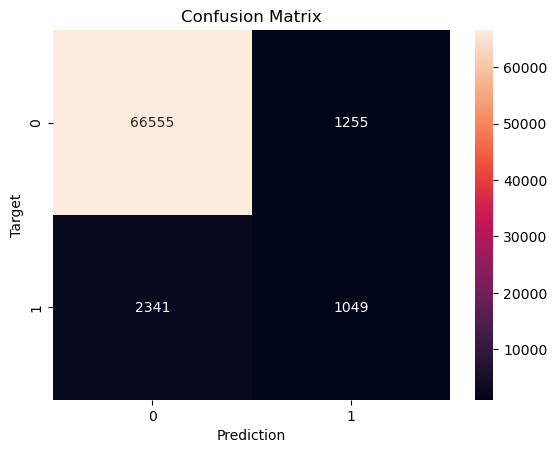

In [117]:
print_confusion_matrix(df_blockDay_test['incidentOccurred?'], df_blockDay_test['Hotspot Prediction'])

In [118]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
print(classification_report(df_blockDay_test['incidentOccurred?'], df_blockDay_test['Hotspot Prediction']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     67810
           1       0.46      0.31      0.37      3390

    accuracy                           0.95     71200
   macro avg       0.71      0.65      0.67     71200
weighted avg       0.94      0.95      0.94     71200



## Random Forest Classifier

In [119]:
df_blockDay_training['lat_bucket'] = pd.qcut(df_blockDay_training['lat'], q=[0,0.2,0.4,0.6,0.8,1], labels=['A','B','C','D','E'])
df_blockDay_training['lng_bucket'] = pd.qcut(df_blockDay_training['lng'], q=[0,0.2,0.4,0.6,0.8,1], labels=['A','B','C','D','E'])

/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/769542800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blockDay_training['lat_bucket'] = pd.qcut(df_blockDay_training['lat'], q=[0,0.2,0.4,0.6,0.8,1], labels=['A','B','C','D','E'])
/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_49498/769542800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blockDay_training['lng_bucket'] = pd.qcut(df_blockDay_training['lng'], q=[0,0.2,0.4,0.6,0.8,1], labels=['A','B','C','D','E'])


In [120]:
df_randomForest = df_blockDay_training[['incidentOccurred?','dayOfWeek','lat_bucket','lng_bucket']]

In [121]:
# Training the random forest classifier model
X_train = df_randomForest.drop('incidentOccurred?',axis=1)
y_train = df_randomForest['incidentOccurred?']

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

ValueError: could not convert string to float: 'Saturday'